In [1]:
from IPython.display import display, Markdown, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from pathlib import Path, PosixPath

# Visual inspection of the beam based alignment measurement

## Notebook setup

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt

from dataclasses import dataclass
# %matplotlib notebook
%matplotlib inline

## Loading data

In [3]:
data_dir = Path(os.getcwd()) / ".." / "bact_analysis_bessyii"/ "scripts"
data_dir = Path(os.path.normpath(data_dir))
data_dir

PosixPath('/home/waheed/workspace/bact/custom/bessyii/analysis/bact_analysis_bessyii/scripts')

In [4]:
os.listdir(data_dir)

['estimated_angles_56f10df6-e502-4a98-96bc-e95aecc6d01f.nc',
 'estimated_angles_f795156c-bf35-49ea-b41a-e47cc03a24bd.nc',
 'offsets_e40cdf68-961a-4220-abdc-46ed19477ed0.nc',
 'estimated_angles_66b70cd9-9827-495b-ab66-7ab8c3f8d890.nc',
 'offsets_66b70cd9-9827-495b-ab66-7ab8c3f8d890.nc',
 'offsets_56f10df6-e502-4a98-96bc-e95aecc6d01f.nc',
 'estimated_angles_d13320af-1a7f-43a1-896c-e8459c417100.nc',
 'estimated_angles_b7a9595f-d555-48a4-b0db-abf53a80125d.nc',
 'offsets_eef1db40-acf9-40c0-97d7-d74e582ef02c.nc',
 'estimated_angles_eef1db40-acf9-40c0-97d7-d74e582ef02c.nc',
 'bba.py',
 'offsets_d13320af-1a7f-43a1-896c-e8459c417100.nc',
 'offsets_08dfc693-e3aa-4fd2-b3cf-2e282298200c.nc',
 'offsets_9e90e2b4-95bf-43a6-9dbd-73a105e28db0.nc',
 'estimated_angles_e40cdf68-961a-4220-abdc-46ed19477ed0.nc',
 'offsets_3c939545-55a1-4524-8467-0472edf71151.nc',
 'estimated_angles_9e90e2b4-95bf-43a6-9dbd-73a105e28db0.nc',
 'estimated_angles_3c939545-55a1-4524-8467-0472edf71151.nc',
 'estimated_angles_08dfc

In [5]:
uid = 'f795156c-bf35-49ea-b41a-e47cc03a24bd'

That's something perhaps to be handled by a (caching) database?

In [6]:
estimated_angles = xr.load_dataset(os.path.join(data_dir, f'estimated_angles_{uid}.nc'))
offsets = xr.load_dataarray(os.path.join(data_dir, f'offsets_{uid}.nc'))

## Display overview of quadrupole offsets

Not developed here: e.g. display a table

| element name | dx | dy | mse | mae |
|:-------------|---:|---:|---:|---:|
| q1m1d1r      | 0.03 | 0.02 | 0.43 | 0.24 |

### Analyse the result for one quadrupole

Visual analysis:

* reproduce fit data (shall one reuse the code ?)

    * read estimated angle for one quadrupole (both planes)
    * read ideal kick
    * scale ideal kick with angle

* read measurement data for one quadrupole

   * subtract the offset
   * see if the deviations correspond to the measured ones

In [7]:
element_name = "q1m1d1r"

Select the magnet data to analyse

In [8]:
estimated_angles


<xarray.Dataset>
Dimensions:     (name: 2, plane: 2, pos: 1364, result: 2, parameter: 110,
                 step: 10, bpm: 109)
Coordinates:
  * name        (name) object 'q1m1d1r' 'q1m1d2r'
  * plane       (plane) object 'x' 'y'
  * pos         (pos) object 'start' 'dg9l2d1r' ... 'dg9l1d1r' 'ringend'
  * result      (result) object 'value' 'error'
  * parameter   (parameter) object 'scaled_angle' 'bpmz6d1r' ... 'bpmz4d1r'
  * step        (step) int64 0 1 2 3 4 5 6 7 8 9
  * bpm         (bpm) object 'BPMZ6D1R' 'BPMZ7D1R' ... 'BPMZ3D1R' 'BPMZ4D1R'
    quality     <U3 'pos'
Data variables:
    orbit       (name, plane, pos) float64 0.0001687 0.0001663 ... -1.297e-05
    fit_params  (name, plane, result, parameter) float64 -0.004964 ... 0.0
    ds          (pos) float64 0.0 0.6155 0.6155 1.137 ... 239.5 240.0 240.0
    ds_elems    (name) float64 232.9 22.89
    x_pos       (name, step, bpm) float64 -1.206e-05 -1.194e-05 ... 1.298e-06
    y_pos       (name, step, bpm) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    x_rms       (name, step, bpm) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    y_rms       (name, step, bpm) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    excitation  (name, step) float64 0.0 0.0 -0.5 -0.5 0.0 ... 0.5 0.5 0.0 0.0
Attributes:
    bpm_names:  ['bpmz6d1r', 'bpmz7d1r', 'bpmz1t1r', 'bpmz2t1r', 'bpmz3t1r', ...

In [9]:
estimated_angles_for_magnet = estimated_angles.sel(name=element_name)
estimated_angles_for_magnet

<xarray.Dataset>
Dimensions:     (plane: 2, pos: 1364, result: 2, parameter: 110, step: 10,
                 bpm: 109)
Coordinates:
    name        <U7 'q1m1d1r'
  * plane       (plane) object 'x' 'y'
  * pos         (pos) object 'start' 'dg9l2d1r' ... 'dg9l1d1r' 'ringend'
  * result      (result) object 'value' 'error'
  * parameter   (parameter) object 'scaled_angle' 'bpmz6d1r' ... 'bpmz4d1r'
  * step        (step) int64 0 1 2 3 4 5 6 7 8 9
  * bpm         (bpm) object 'BPMZ6D1R' 'BPMZ7D1R' ... 'BPMZ3D1R' 'BPMZ4D1R'
    quality     <U3 'pos'
Data variables:
    orbit       (plane, pos) float64 0.0001687 0.0001663 ... 1.074e-05 1.074e-05
    fit_params  (plane, result, parameter) float64 -0.004964 -1.2e-05 ... 0.0
    ds          (pos) float64 0.0 0.6155 0.6155 1.137 ... 239.5 240.0 240.0
    ds_elems    float64 232.9
    x_pos       (step, bpm) float64 -1.206e-05 -1.194e-05 ... 1.298e-06
    y_pos       (step, bpm) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    x_rms       (step, bpm) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    y_rms       (step, bpm) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    excitation  (step) float64 0.0 0.0 -0.5 -0.5 0.0 0.0 0.5 0.5 0.0 0.0
Attributes:
    bpm_names:  ['bpmz6d1r', 'bpmz7d1r', 'bpmz1t1r', 'bpmz2t1r', 'bpmz3t1r', ...

## Prepare comparison between measured data and calculated data

The orbit stored in the data was calculated for a steerer placed at the element producing a
kick of some value $\vartheta$

The visual analysis of measured data to estimated fit requires

1. reduce the offsets of the BPM"s from the measurements
   These offsets are stored in the fit data results

2. scale the orbit which was made for some value $\vartheta$ with the fit value $\vartheta_f$ by

   $$
       orbit \cdot \vartheta_f / \vartheta
   $$

3. plot the data:

    1. all together to see if the offsets are sensible
    2. measured and calculated with the bpm offsets reduced



In [10]:
ref_angle = estimated_angles_for_magnet.orbit.attrs['theta']

### Plot the orbit as stored just to see

Text(0.5, 0, 'ds [m]')

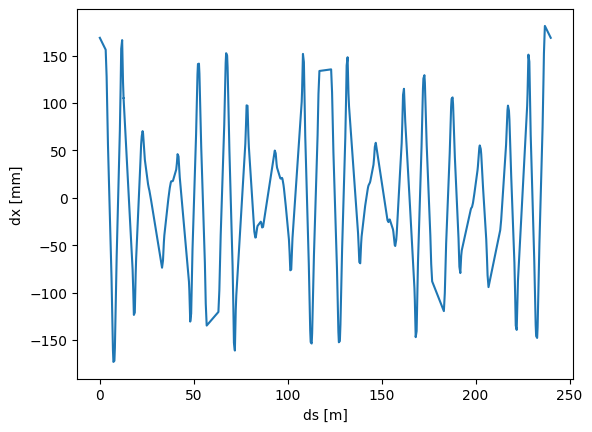

In [11]:
pscale = 1e6
fig, ax = plt.subplots(1, 1)
ax.plot(
    estimated_angles_for_magnet.ds, estimated_angles_for_magnet.orbit.sel(plane="x") * pscale
)
ax.set_ylabel("dx [mm]")
ax.set_xlabel("ds [m]")

Need to retrieve the bpm names: want to extract the offset from the fit
Luckily its an attribute

In [12]:
bpm_names = estimated_angles.attrs['bpm_names']

In [13]:
bpm_offsets = estimated_angles_for_magnet.fit_params.sel(parameter=bpm_names).rename(parameter="pos")
bpm_offsets

<xarray.DataArray 'fit_params' (plane: 2, result: 2, pos: 109)>
array([[[-1.20038045e-05, -1.18882223e-05, -1.17307146e-05,
         -6.52647076e-06,  8.13795313e-06,  1.28363818e-05,
          7.35647132e-06, -7.86348904e-06, -7.69266237e-06,
          3.45351539e-06,  5.15700838e-06,  6.30858650e-06,
         -2.24262788e-06, -4.97206515e-06, -3.61272429e-06,
         -8.79018992e-07,  2.82581626e-08,  4.96227641e-06,
          3.66754324e-06,  1.41995416e-07, -1.00839130e-06,
         -1.23226897e-06, -2.71618353e-06, -1.48850460e-06,
          6.43132061e-06,  6.23936663e-06, -6.55301986e-06,
         -1.06197224e-05, -6.24580829e-06,  5.61640666e-06,
          9.84441857e-06,  9.20648483e-06,  5.01956877e-06,
         -7.21820836e-06, -1.11304926e-05, -6.20887258e-06,
          7.83392475e-06,  7.61475142e-06,  4.02390314e-06,
          1.00358601e-06, -3.77657246e-06, -5.07626879e-06,
          7.78337735e-07,  2.65470811e-06,  2.27888190e-06,
          2.23720335e-06,  2.27876128e-06, -3.11951296e-06,
         -2.71855567e-06, -1.79880324e-06, -1.48738136e-06,
         -1.37438201e-07,  4.57807342e-06,  3.25315261e-06,
         -7.56401397e-06, -7.65072621e-06,  7.00853673e-06,
          1.16795720e-05,  7.02241148e-06, -5.43382300e-06,
...
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00]]])
Coordinates:
    name     <U7 'q1m1d1r'
  * plane    (plane) object 'x' 'y'
  * result   (result) object 'value' 'error'
  * pos      (pos) object 'bpmz6d1r' 'bpmz7d1r' ... 'bpmz3d1r' 'bpmz4d1r'
    quality  <U3 'pos'

In [14]:
bpm_offsets.sel(plane="x", result="value")

<xarray.DataArray 'fit_params' (pos: 109)>
array([-1.20038045e-05, -1.18882223e-05, -1.17307146e-05, -6.52647076e-06,
        8.13795313e-06,  1.28363818e-05,  7.35647132e-06, -7.86348904e-06,
       -7.69266237e-06,  3.45351539e-06,  5.15700838e-06,  6.30858650e-06,
       -2.24262788e-06, -4.97206515e-06, -3.61272429e-06, -8.79018992e-07,
        2.82581626e-08,  4.96227641e-06,  3.66754324e-06,  1.41995416e-07,
       -1.00839130e-06, -1.23226897e-06, -2.71618353e-06, -1.48850460e-06,
        6.43132061e-06,  6.23936663e-06, -6.55301986e-06, -1.06197224e-05,
       -6.24580829e-06,  5.61640666e-06,  9.84441857e-06,  9.20648483e-06,
        5.01956877e-06, -7.21820836e-06, -1.11304926e-05, -6.20887258e-06,
        7.83392475e-06,  7.61475142e-06,  4.02390314e-06,  1.00358601e-06,
       -3.77657246e-06, -5.07626879e-06,  7.78337735e-07,  2.65470811e-06,
        2.27888190e-06,  2.23720335e-06,  2.27876128e-06, -3.11951296e-06,
       -2.71855567e-06, -1.79880324e-06, -1.48738136e-06, -1.37438201e-07,
        4.57807342e-06,  3.25315261e-06, -7.56401397e-06, -7.65072621e-06,
        7.00853673e-06,  1.16795720e-05,  7.02241148e-06, -5.43382300e-06,
       -9.88724532e-06, -1.01982426e-05, -5.78388277e-06,  7.10380367e-06,
        1.12576840e-05,  6.46816852e-06, -6.95637185e-06, -7.06167445e-06,
        2.12912435e-06,  3.43455095e-06,  7.93873713e-07, -6.15851788e-08,
       -7.32670354e-07, -3.48666592e-06, -4.51954938e-06, -4.05952475e-06,
       -2.25523639e-06, -1.55794600e-06,  4.17572971e-07,  1.42563272e-06,
        3.40989951e-06,  4.01955634e-06,  1.57383235e-06, -6.27741049e-06,
       -6.28322310e-06, -4.31089297e-07,  7.02916033e-06,  7.76596102e-06,
       -5.47181502e-06, -9.72457208e-06, -6.15548793e-06,  2.96390643e-06,
        6.18247999e-06,  8.94537560e-06,  5.47708601e-06, -4.59237747e-06,
       -7.85064366e-06, -4.81823712e-06,  3.27486459e-06,  3.91019818e-06,
        1.56404181e-06,  6.12942916e-07, -3.55912211e-06, -4.87882972e-06,
       -2.40017057e-06,  4.96191587e-06,  7.61668915e-06,  3.61148690e-06,
        1.29221051e-06])
Coordinates:
    name     <U7 'q1m1d1r'
    plane    <U1 'x'
    result   <U5 'value'
  * pos      (pos) object 'bpmz6d1r' 'bpmz7d1r' ... 'bpmz3d1r' 'bpmz4d1r'
    quality  <U3 'pos'

In [15]:
orbit_at_bpm = estimated_angles_for_magnet.orbit.sel(pos=bpm_names)
ds_at_bpm = estimated_angles_for_magnet.ds.sel(pos=bpm_names)
ds_at_bpm

<xarray.DataArray 'ds' (pos: 109)>
array([  3.995   ,   6.474   ,   7.675   ,   8.591   ,  11.005   ,
        12.639   ,  17.361   ,  18.995   ,  21.474   ,  22.675   ,
        23.591   ,  26.005   ,  27.264   ,  32.736   ,  33.995   ,
        36.474   ,  37.675   ,  38.591   ,  41.005   ,  42.639   ,
        47.361   ,  48.995   ,  51.474   ,  52.675   ,  53.591   ,
        56.005   ,  57.264   ,  62.736   ,  63.995   ,  66.474   ,
        67.675   ,  71.005   ,  72.639   ,  77.361   ,  78.995   ,
        81.474   ,  82.675   ,  83.591   ,  86.005   ,  87.264   ,
        92.736   ,  93.995   ,  97.675   ,  98.591   , 101.005   ,
       102.639   , 107.361   , 108.995   , 111.474   , 112.675   ,
       113.591   , 116.005   , 117.773363, 122.386765, 123.995   ,
       126.474   , 127.675   , 128.591   , 131.005   , 132.639   ,
       137.361   , 138.995   , 141.474   , 142.675   , 143.591   ,
       146.005   , 147.264   , 154.00339 , 156.48239 , 157.68339 ,
       158.59939 , 161.01339 , 162.64739 , 164.74399 , 167.36939 ,
       169.00339 , 171.48239 , 172.68339 , 173.59939 , 176.01339 ,
       177.27239 , 182.74439 , 184.00339 , 186.48239 , 187.68339 ,
       188.59939 , 191.01339 , 192.64739 , 197.36939 , 199.00339 ,
       201.48239 , 202.68339 , 203.59939 , 206.01339 , 207.27239 ,
       212.74439 , 214.00339 , 216.48239 , 217.68339 , 218.59939 ,
       221.01339 , 222.64739 , 227.36939 , 229.00339 , 231.48239 ,
       232.68339 , 233.59939 , 236.01339 , 237.27239 ])
Coordinates:
    name     <U7 'q1m1d1r'
  * pos      (pos) object 'bpmz6d1r' 'bpmz7d1r' ... 'bpmz3d1r' 'bpmz4d1r'
    quality  <U3 'pos'
Attributes:
    coordinates:  par

In [16]:
estimated_angles_for_magnet

<xarray.Dataset>
Dimensions:     (plane: 2, pos: 1364, result: 2, parameter: 110, step: 10,
                 bpm: 109)
Coordinates:
    name        <U7 'q1m1d1r'
  * plane       (plane) object 'x' 'y'
  * pos         (pos) object 'start' 'dg9l2d1r' ... 'dg9l1d1r' 'ringend'
  * result      (result) object 'value' 'error'
  * parameter   (parameter) object 'scaled_angle' 'bpmz6d1r' ... 'bpmz4d1r'
  * step        (step) int64 0 1 2 3 4 5 6 7 8 9
  * bpm         (bpm) object 'BPMZ6D1R' 'BPMZ7D1R' ... 'BPMZ3D1R' 'BPMZ4D1R'
    quality     <U3 'pos'
Data variables:
    orbit       (plane, pos) float64 0.0001687 0.0001663 ... 1.074e-05 1.074e-05
    fit_params  (plane, result, parameter) float64 -0.004964 -1.2e-05 ... 0.0
    ds          (pos) float64 0.0 0.6155 0.6155 1.137 ... 239.5 240.0 240.0
    ds_elems    float64 232.9
    x_pos       (step, bpm) float64 -1.206e-05 -1.194e-05 ... 1.298e-06
    y_pos       (step, bpm) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    x_rms       (step, bpm) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    y_rms       (step, bpm) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    excitation  (step) float64 0.0 0.0 -0.5 -0.5 0.0 0.0 0.5 0.5 0.0 0.0
Attributes:
    bpm_names:  ['bpmz6d1r', 'bpmz7d1r', 'bpmz1t1r', 'bpmz2t1r', 'bpmz3t1r', ...

In [17]:
#bpm_offsets.sel(plane="x", result="value").rename(fit_parameters="pos")

Text(0.5, 0, 'ds [m]')

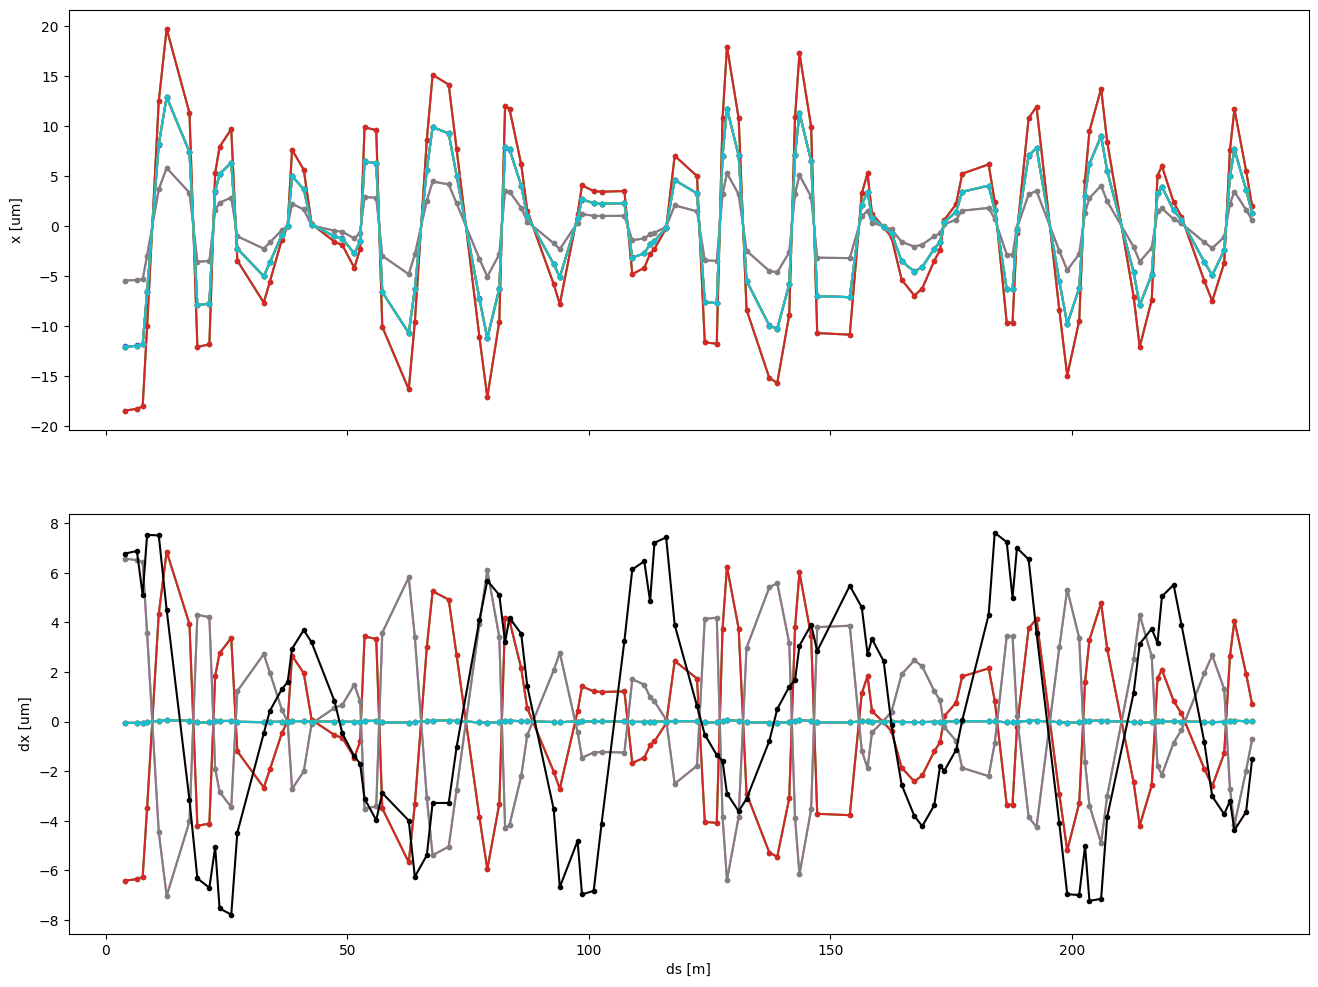

In [18]:
pscale = 1e6
fig, axes = plt.subplots(2, 1, sharex=True, figsize=[16, 12])
ax, ax_diff = axes
# difference to orbit for quadrupole with piggy pack power converter at 0
# well not exactly ... for where it would be if the magnet was ideal and
# had no  hysteresis etc.

ax.plot(ds_at_bpm, bpm_offsets.sel(plane="x", result="value") * pscale, 'b.')
for cnt, x in enumerate(estimated_angles_for_magnet.x_pos):
    line, = ax.plot(ds_at_bpm, x * pscale, '.-')
    dx = x.values - bpm_offsets.sel(plane="x", result="value").values
    ax_diff.plot(ds_at_bpm, dx * pscale, '.-', color=line.get_color())

ax_diff.plot(ds_at_bpm, orbit_at_bpm.sel(plane="y") * pscale / 10, '.-', color='k')

ax.set_ylabel("x [um]")
ax_diff.set_ylabel("dx [um]")
ax_diff.set_xlabel("ds [m]")

Text(0.5, 0, 'ds [m]')

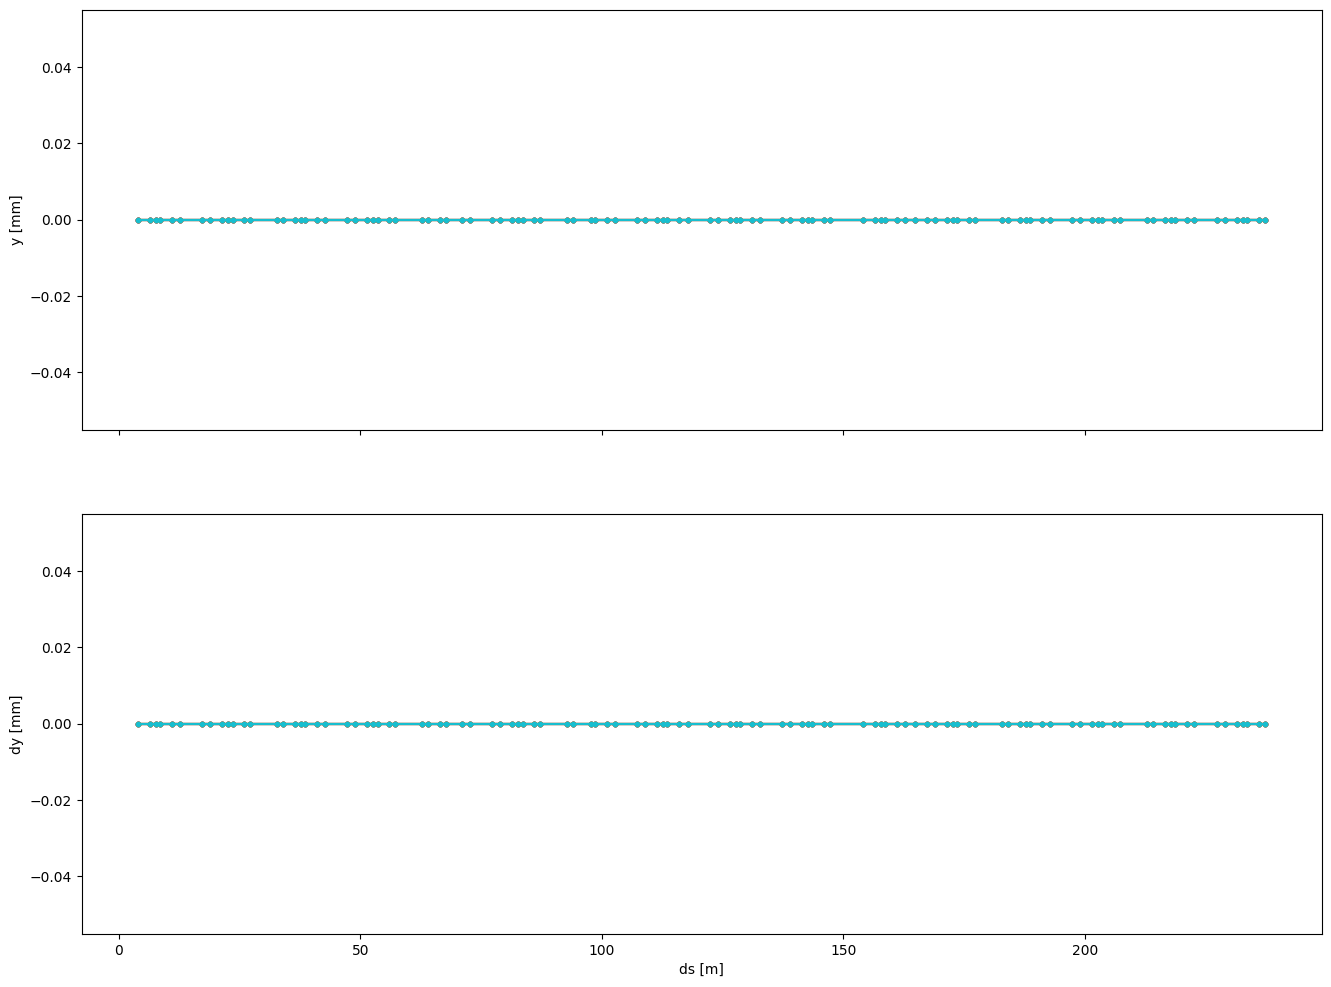

In [19]:
pscale = 1e6
fig, axes = plt.subplots(2, 1, sharex=True, figsize=[16, 12])
ax, ax_diff = axes
# difference to orbit for quadrupole with piggy pack power converter at 0
# well not exactly ... for where it would be if the magnet was ideal and
# had no  hysteresis etc.

ax.plot(ds_at_bpm,  bpm_offsets.sel(plane="y", result="value") * pscale, 'b.')
for cnt, y in enumerate(estimated_angles_for_magnet.y_pos):
    line, = ax.plot(ds_at_bpm, y * pscale, '.-')
    dy = y.values - bpm_offsets.sel(plane="y", result="value").values
    ax_diff.plot(ds_at_bpm, dy * pscale, '.-', color=line.get_color())

#ax_diff.plot(ds_at_bpm, orbit_at_bpm.sel(plane="y") * pscale / 10, '.-', color='k')

ax.set_ylabel("y [mm]")
ax_diff.set_ylabel("dy [mm]")
ax_diff.set_xlabel("ds [m]")

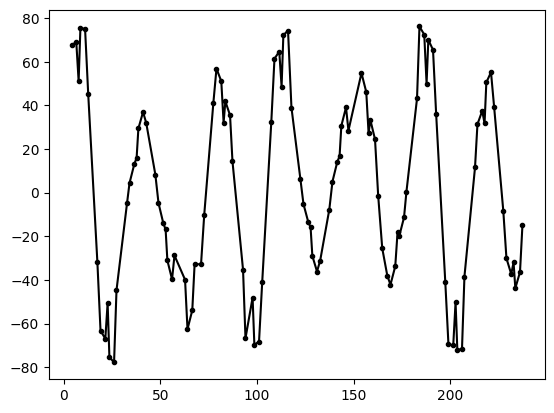

In [20]:
plt.plot(ds_at_bpm, orbit_at_bpm.sel(plane="y") * 1e6, '.-', color='k')

Text(0.5, 0, 'ds [m]')

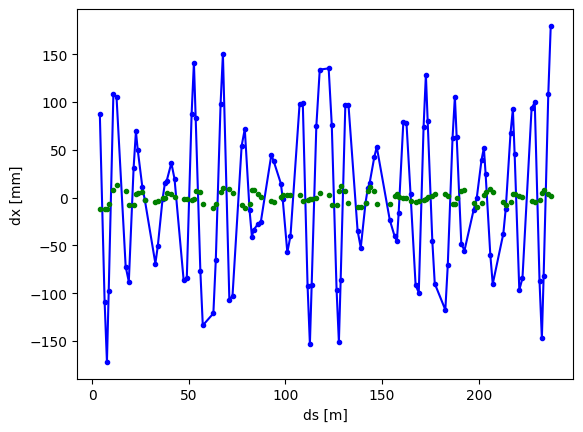

In [21]:
pscale = 1e6
fig, ax = plt.subplots(1, 1)

# difference to orbit for quadrupole with piggy pack power converter at 0
# well not exactly ... for where it would be if the magnet was ideal and
# had no  hysteresis etc.
dx = orbit_at_bpm.sel(plane="x")
ax.plot(
     ds_at_bpm, dx * pscale, 'b.-',
    ds_at_bpm,  bpm_offsets.sel(plane="x", result="value") * pscale, 'g.'
)
ax.set_ylabel("dx [mm]")
ax.set_xlabel("ds [m]")

In [22]:
offsets.sel(result="error", plane="x")

<xarray.DataArray (name: 2)>
array([1.34077537e-06, 2.67542499e-08])
Coordinates:
    plane    <U1 'x'
    result   <U5 'error'
  * name     (name) object 'q1m1d1r' 'q1m1d2r'

## Cross check to data provided by digital twin

### Twiss data as provided by the twin

In [23]:
import epics

In [24]:
offsets.sel(name="q1m1d1r", plane="x") * 1e3

<xarray.DataArray (result: 2)>
array([-0.00264049,  0.00134078])
Coordinates:
    plane    <U1 'x'
  * result   (result) object 'value' 'error'
    name     <U7 'q1m1d1r'

In [25]:
orbit_x_pv =  epics.PV("Pierre:DT:beam:orbit:x")
orbit_y_pv =  epics.PV("Pierre:DT:beam:orbit:y")
beta_x_pv =  epics.PV("Pierre:DT:beam:beta:x")
beta_y_pv =  epics.PV("Pierre:DT:beam:beta:y")
mu_x_pv =  epics.PV("Pierre:DT:beam:nu:x")
mu_y_pv =  epics.PV("Pierre:DT:beam:nu:y")
s_pv =  epics.PV("Pierre:DT:beam:s")
orbit_names = epics.PV("Pierre:DT:beam:names")

In [26]:
mu_x_pv.get();

In [27]:
data = np.transpose([pv.get() for pv in (orbit_x_pv, orbit_y_pv, beta_x_pv, beta_y_pv, mu_x_pv, mu_y_pv, s_pv)])
twin_twiss_df = pd.DataFrame(data, columns=["x", "y", "beta_x", "beta_y", "mu_x", "mu_y", "ds"], index=orbit_names.get())
twin_twiss_df.tail()

CA.Client.Exception...............................................
    Context: "Channel: "Pierre:DT:beam:orbit:x", Connecting to: 134.30.239.141:5064, Ignored: waheed-Precision-3560:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Jun 05 2023 18:03:34.697015399
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "Pierre:DT:beam:orbit:y", Connecting to: 134.30.239.141:5064, Ignored: waheed-Precision-3560:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Jun 05 2023 18:03:34.698049786
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "Pierre:DT:beam:beta:x", Connecting to: 134.30.239.141:5064, Ignored: waheed-Precision-3560:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Mon Jun 05 2023 18:03:34.698995599
...........................

,x,y,beta_x,beta_y,mu_x,mu_y,ds
de9l1d1r,-0.000013,0.0,17.188004,4.268597,17.837390,6.676110,238.82889
df9l1d1r,-0.000013,0.0,16.998257,3.723834,17.843588,6.702802,239.49439
m_fomz1d1r,-0.000013,0.0,16.998257,3.723834,17.843588,6.702802,239.49439
dg9l1d1r,-0.000013,0.0,16.887909,3.481666,17.848417,6.725599,240.00839
ringend,-0.000013,0.0,16.887909,3.481666,17.848417,6.725599,240.00839


### Comparing used orbit distortom

The one from the twin data to the one used during calculation

In [28]:
element_name

'q1m1d1r'

In [29]:
from bact_math_utils.distorted_orbit import closed_orbit_distortion
orbit_x = closed_orbit_distortion(
    twin_twiss_df.beta_x, twin_twiss_df.mu_x * 2*np.pi, tune=twin_twiss_df.mu_x.iloc[-1],
    beta_i=twin_twiss_df.loc[element_name, 'beta_x'],
    mu_i=twin_twiss_df.loc[element_name, 'mu_x'] * 2*np.pi,
    theta_i=1e-5,
)

Text(0, 0.5, 'x [um]')

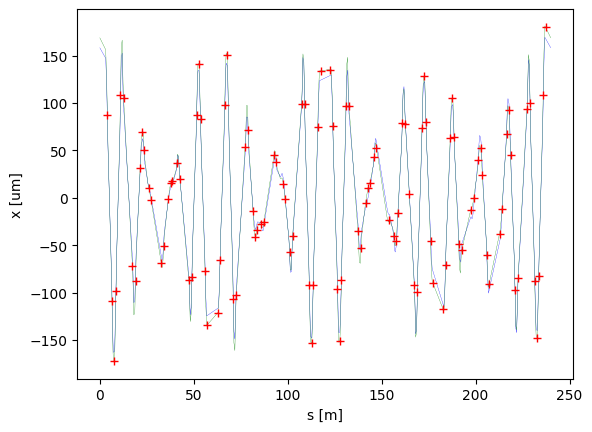

In [30]:
pscale = 1e6
fig, ax = plt.subplots()
ax.plot(twin_twiss_df.ds, orbit_x * pscale, '-b',
         estimated_angles_for_magnet.ds, estimated_angles_for_magnet.orbit.sel(plane="x") * pscale, '-g',
        ds_at_bpm,orbit_at_bpm.sel(plane='x') * pscale, '+r',
        linewidth=.2
        )
ax.set_xlabel('s [m]')
ax.set_ylabel('x [um]')

In [31]:
bpm_names = [name for name in twin_twiss_df.index if name[:3] == "bpm"  ]
bpm_names, len(bpm_names)

(['bpmz43d1r',
  'bpmz44d1r',
  'bpmz5d1r',
  'bpmz6d1r',
  'bpmz7d1r',
  'bpmz1t1r',
  'bpmz2t1r',
  'bpmz3t1r',
  'bpmz4t1r',
  'bpmz43t1r',
  'bpmz5t1r',
  'bpmz6t1r',
  'bpmz7t1r',
  'bpmz1d2r',
  'bpmz2d2r',
  'bpmz3d2r',
  'bpmz4d2r',
  'bpmz5d2r',
  'bpmz6d2r',
  'bpmz7d2r',
  'bpmz1t2r',
  'bpmz2t2r',
  'bpmz3t2r',
  'bpmz4t2r',
  'bpmz5t2r',
  'bpmz6t2r',
  'bpmz7t2r',
  'bpmz1d3r',
  'bpmz2d3r',
  'bpmz3d3r',
  'bpmz4d3r',
  'bpmz5d3r',
  'bpmz6d3r',
  'bpmz7d3r',
  'bpmz1t3r',
  'bpmz2t3r',
  'bpmz3t3r',
  'bpmz4t3r',
  'bpmz41t3r',
  'bpmz42t3r',
  'bpmz5t3r',
  'bpmz6t3r',
  'bpmz7t3r',
  'bpmz1d4r',
  'bpmz2d4r',
  'bpmz3d4r',
  'bpmz4d4r',
  'bpmz5d4r',
  'bpmz6d4r',
  'bpmz7d4r',
  'bpmz1t4r',
  'bpmz2t4r',
  'bpmz3t4r',
  'bpmz4t4r',
  'bpmz5t4r',
  'bpmz6t4r',
  'bpmz7t4r',
  'bpmz1d5r',
  'bpmz2d5r',
  'bpmz3d5r',
  'bpmz4d5r',
  'bpmz5d5r',
  'bpmz6d5r',
  'bpmz7d5r',
  'bpmz1t5r',
  'bpmz2t5r',
  'bpmz3t5r',
  'bpmz4t5r',
  'bpmz5t5r',
  'bpmz6t5r',
  'bpmz7t5r',
 

In [32]:
bpm_indices = [ name[:3] == "bpm"  for name in twin_twiss_df.index]

In [33]:
twin_twiss_df.index[bpm_names]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### middle offset to beam offset

In [ ]:
factor = 5.4
fig, ax = plt.subplots(figsize=[16, 12])
ax.plot(
    twin_twiss_df.ds, orbit_x * pscale * factor, '.-b',
    twin_twiss_df.ds[bpm_indices], orbit_x[bpm_indices] * pscale * 5.3, 'r+-',
    ds_at_bpm, orbit_at_bpm.sel(plane="x") * pscale * factor, 'k+',
    #ds_at_bpm, bpm_offsets.sel(plane="x", result="value") * pscale, 'gx-',
    twin_twiss_df.ds, twin_twiss_df.x * pscale, '.r',
    linewidth=.2
)



In [ ]:
from bact_analysis.transverse.calc import for_fitting_reference_orbit
dir(bact_analysis.transverse.calc)

In [ ]:
dx_q1_pv.get() - df.loc['q1m1d1r', :] * 1e3


In [ ]:
(df*1000).plot()

In [ ]:
plt.plot(
    estimated_angles_for_magnet.ds.sel(pos=df.index), df.x * 1000
)

In [ ]:
dx_q1_pv = epics.PV("Pierre:DT:q1m1d1r:x:rdbk")

In [ ]:
set(df.index.values).difference(set(estimated_angles_for_magnet.ds.coords['pos'].values)),
set(estimated_angles_for_magnet.ds.coords['pos'].values).difference(set(df.index.values))

In [ ]:
df.index[:2]